In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [2]:
from pathlib import Path

# Configurable parts
SYMBOL = "USDJPY"
SAMPLE_TYPE = "time"
MINUTES = 1
DOLLAR_THRESHOLD = "115009542m"
EVENT_NAME = "CUSUM"
EVENT_THRESHOLD = 2.52e-04

START_DATE = "20210101"
END_DATE = "20241231"

# Build base name
if SAMPLE_TYPE == "dollar":
    RESAMPLED_NAME = f"{SYMBOL}-{DOLLAR_THRESHOLD}-dollar-{START_DATE}-{END_DATE}"
else:
    RESAMPLED_NAME = f"{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"

# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
PROCESSED_DIR = BASE_DIR / "processed"
EVENTS_DIR = BASE_DIR / "events"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}_processed.pkl"
EVENT_FILE_PATH = EVENTS_DIR / f"{RESAMPLED_NAME}_{EVENT_NAME}_{EVENT_THRESHOLD:.2e}.pkl"

In [3]:
DIRECTION_LABEL_DIR = BASE_DIR / "direction_labels"
DIRECTION_LABEL_DIR.mkdir(parents=True, exist_ok=True)
DIRECTION_LABEL_FILE_PATH = DIRECTION_LABEL_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}.pkl"

In [4]:
%%time
df = pd.read_pickle(PROCESSED_FILE_PATH)
t_events = pd.read_pickle(EVENT_FILE_PATH)

CPU times: user 869 μs, sys: 59.5 ms, total: 60.4 ms
Wall time: 89.3 ms


In [5]:
df.loc[t_events].head()

,open,high,low,close,volume,spread,log_volume,close_delta,close_return,close_log_return,...,hour_cos,dow,dow_sin,dow_cos,dom,dom_sin,dom_cos,month,month_sin,month_cos
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-03 23:00:00,103.2220,103.2430,103.2085,103.2420,2.735700e+11,0.025980,26.334823,0.0205,0.000199,0.000199,...,0.965926,6,-0.781831,0.62349,3,0.571268,0.820763,1,0.5,0.866025
2021-01-03 23:10:00,103.2455,103.2605,103.2445,103.2605,1.086800e+11,0.008721,25.411674,0.0145,0.000140,0.000140,...,0.965926,6,-0.781831,0.62349,3,0.571268,0.820763,1,0.5,0.866025
2021-01-03 23:20:00,103.2740,103.2945,103.2735,103.2945,1.750200e+11,0.005963,25.888166,0.0180,0.000174,0.000174,...,0.965926,6,-0.781831,0.62349,3,0.571268,0.820763,1,0.5,0.866025
2021-01-03 23:30:00,103.2955,103.3130,103.2815,103.2825,2.825600e+11,0.003088,26.367157,-0.0115,-0.000111,-0.000111,...,0.965926,6,-0.781831,0.62349,3,0.571268,0.820763,1,0.5,0.866025
2021-01-03 23:32:00,103.2650,103.2660,103.2425,103.2455,1.582300e+11,0.004196,25.787316,-0.0225,-0.000218,-0.000218,...,0.965926,6,-0.781831,0.62349,3,0.571268,0.820763,1,0.5,0.866025


## Calculate Target Volatility (trgt)
This will be used for the calculation of dynamic TP/SL

In [6]:
def get_daily_vol(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    #bp()
    df0=df0[df0>0]
    #bp()
    df0=(pd.Series(close.index[df0-1],
                   index=close.index[close.shape[0]-df0.shape[0]:]))
    #bp()
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(e)
        print('adjusting shape of close.loc[df0.index]')
        cut = close.loc[df0.index].shape[0] - close.loc[df0.values].shape[0]
        df0=close.loc[df0.index].iloc[:-cut]/close.loc[df0.values].values-1
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

In [7]:
from ta.volatility import AverageTrueRange

def get_atr(df, window=60):
    atr = AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=window)
    return atr.average_true_range().rename(f"atr{window}")

In [8]:
trgt = get_daily_vol(df['close']).reindex(t_events, method='ffill')

In [9]:
df['atr14_price'] = get_atr(df, window=14)

In [10]:
df['atr14_ret'] = df['atr14_price'] / df['close'].shift(1)

In [11]:
trgt = df['atr14_ret'].shift(1).reindex(t_events, method='ffill')

In [12]:
trgt.describe()

count    248998.000000
mean          0.000245
std           0.000186
min           0.000000
25%           0.000134
50%           0.000202
75%           0.000296
max           0.003291
Name: atr14_ret, dtype: float64

## Apply Triple Barrier
We use daily volatility to calculate TP/SL, and we set our T1 as 1day

In [13]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import pandas as pd

def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    
    pt = ptSl[0] * events_['trgt'] if ptSl[0] > 0 else pd.Series(index=events.index)
    sl = -ptSl[1] * events_['trgt'] if ptSl[1] > 0 else pd.Series(index=events.index)

        
    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
        
    return out


def parallel_apply(func, items, num_threads=4, **kwargs):
    
    def worker(molecule):
        return func(molecule=molecule, **kwargs)

    chunks = np.array_split(items, num_threads)
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(executor.map(worker, chunks))

    return pd.concat(results).sort_index()


def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads=4, t1=False, side=None):
    # Step 1: Filter targets
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt > minRet]

    # Step 2: Set vertical barrier (t1)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)

    # Step 3: Build events DataFrame
    if side is None:
        side_, ptSl_ = pd.Series(1., index=trgt.index), [ptSl[0], ptSl[0]]
    else:
        side_, ptSl_ = side.loc[trgt.index], ptSl[:2]

    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_}, axis=1).dropna(subset=['trgt'])

    # Step 4: Apply barriers in parallel
    df0 = parallel_apply(
        func=applyPtSlOnT1,
        items=events.index,
        num_threads=numThreads,
        close=close,
        events=events,
        ptSl=ptSl_
    )

    # Step 5: Choose the first touched barrier
    events['t1'] = df0.dropna(how='all').min(axis=1)
    
    if side is None:
        events = events.drop('side', axis=1)
        
    return events


In [14]:
def get_vertical_barrier(t_events, close, delta=pd.Timedelta(minutes=60)):
    """
    For each event in t_events, find the timestamp in close.index 
    that is at least delta later. Returns a pd.Series of t1.
    """
    barrier_times = t_events + delta
    t1_idx = close.index.searchsorted(barrier_times)
    valid_idx = t1_idx[t1_idx < len(close)]
    t1 = pd.Series(close.index[valid_idx], index=t_events[:len(valid_idx)])
    return t1

In [15]:
t1 = get_vertical_barrier(t_events, df['close'], delta=pd.Timedelta(minutes=60))

In [16]:
t1

timestamp
2021-01-03 23:00:00   2021-01-04 00:00:00
2021-01-03 23:10:00   2021-01-04 00:10:00
2021-01-03 23:20:00   2021-01-04 00:20:00
2021-01-03 23:30:00   2021-01-04 00:30:00
2021-01-03 23:32:00   2021-01-04 00:32:00
                              ...        
2024-12-30 21:06:00   2024-12-30 22:06:00
2024-12-30 21:45:00   2024-12-30 22:50:00
2024-12-30 21:48:00   2024-12-30 22:50:00
2024-12-30 22:05:00   2024-12-30 23:05:00
2024-12-30 22:29:00   2024-12-30 23:29:00
Name: timestamp, Length: 248989, dtype: datetime64[ns]

In [17]:
%%time

events = getEvents(
    close=df['close'],
    tEvents=t_events, 
    ptSl=[.5,.5], 
    trgt=trgt, 
    minRet=0, 
    numThreads=8, 
    t1=t1, 
    side=None
)

CPU times: user 1min 11s, sys: 6.87 s, total: 1min 18s
Wall time: 1min 12s


In [18]:
events

,t1,trgt
timestamp,,
2021-01-03 23:10:00,2021-01-03 23:17:00,0.000110
2021-01-03 23:20:00,2021-01-03 23:24:00,0.000101
2021-01-03 23:30:00,2021-01-03 23:31:00,0.000107
2021-01-03 23:32:00,2021-01-03 23:33:00,0.000132
2021-01-03 23:35:00,2021-01-03 23:36:00,0.000139
...,...,...
2024-12-30 23:17:00,2024-12-30 23:18:00,0.000104
2024-12-30 23:18:00,2024-12-30 23:22:00,0.000111
2024-12-30 23:35:00,2024-12-30 23:37:00,0.000097


In [19]:
events = events.dropna().copy()

In [20]:
events['duration'] = events['t1'] - events.index
events['duration'].describe()

count                       248997
mean     0 days 00:03:02.743888480
std      0 days 00:51:02.960265239
min                0 days 00:01:00
25%                0 days 00:01:00
50%                0 days 00:02:00
75%                0 days 00:03:00
max                2 days 01:01:00
Name: duration, dtype: object

In [21]:
longest_idx = events['duration'].idxmax()
longest_event = events.loc[longest_idx]
print(f"Longest event index: {longest_idx}")
print(longest_event)

Longest event index: 2021-11-05 20:59:00
t1          2021-11-07 22:00:00
trgt                   0.000073
duration        2 days 01:01:00
Name: 2021-11-05 20:59:00, dtype: object


# Keep only intraday events

In [22]:
events = events[events.index.date==events.t1.dt.date]

## Create classification labels

In [23]:
def getBins(events, close, t1=None):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is original vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    # 1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    # 2) create out object
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[
        events_.index] - 1
    if 'side' in events_: out['ret'] *= events_['side']  # meta-labeling
    out['bin'] = np.sign(out['ret'])

    if 'side' not in events_:
        # only applies when not meta-labeling.
        # to update bin to 0 when vertical barrier is touched, we need the
        # original vertical barrier series since the events['t1'] is the time
        # of first touch of any barrier and not the vertical barrier
        # specifically. The index of the intersection of the vertical barrier
        # values and the events['t1'] values indicate which bin labels needs
        # to be turned to 0.
        vtouch_first_idx = events[events['t1'].isin(t1.values)].index
        out.loc[vtouch_first_idx, 'bin'] = 0.

    if 'side' in events_: out.loc[out['ret'] <= 0, 'bin'] = 0  # meta-labeling
    return out

In [24]:
labels = getBins(events, df['close'], t1=t1)
labels["bin_class"] = labels["bin"] + 1
labels

,ret,bin,bin_class
timestamp,,,
2021-01-03 23:10:00,0.000073,1.0,2.0
2021-01-03 23:20:00,-0.000077,-1.0,0.0
2021-01-03 23:30:00,-0.000140,-1.0,0.0
2021-01-03 23:32:00,0.000121,1.0,2.0
2021-01-03 23:35:00,0.000082,1.0,2.0
...,...,...,...
2024-12-30 23:17:00,-0.000293,-1.0,0.0
2024-12-30 23:18:00,0.000089,1.0,2.0
2024-12-30 23:35:00,0.000169,1.0,2.0


In [25]:
labels.bin.value_counts()

bin
 1.0    95911
-1.0    93518
 0.0    59205
Name: count, dtype: int64

In [26]:
labeled_events = events.join(labels, how='inner')

In [27]:
labeled_events.head()

,t1,trgt,duration,ret,bin,bin_class
timestamp,,,,,,
2021-01-03 23:10:00,2021-01-03 23:17:00,0.000110,0 days 00:07:00,0.000073,1.0,2.0
2021-01-03 23:20:00,2021-01-03 23:24:00,0.000101,0 days 00:04:00,-0.000077,-1.0,0.0
2021-01-03 23:30:00,2021-01-03 23:31:00,0.000107,0 days 00:01:00,-0.000140,-1.0,0.0
2021-01-03 23:32:00,2021-01-03 23:33:00,0.000132,0 days 00:01:00,0.000121,1.0,2.0
2021-01-03 23:35:00,2021-01-03 23:36:00,0.000139,0 days 00:01:00,0.000082,1.0,2.0


In [28]:
df.loc[labeled_events.index]

,open,high,low,close,volume,spread,log_volume,close_delta,close_return,close_log_return,...,dow_sin,dow_cos,dom,dom_sin,dom_cos,month,month_sin,month_cos,atr14_price,atr14_ret
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-03 23:10:00,103.2455,103.2605,103.2445,103.2605,1.086800e+11,0.008721,25.411674,0.0145,0.000140,0.000140,...,-0.781831,0.62349,3,0.571268,0.820763,1,5.000000e-01,0.866025,0.011692,0.000113
2021-01-03 23:20:00,103.2740,103.2945,103.2735,103.2945,1.750200e+11,0.005963,25.888166,0.0180,0.000174,0.000174,...,-0.781831,0.62349,3,0.571268,0.820763,1,5.000000e-01,0.866025,0.011202,0.000108
2021-01-03 23:30:00,103.2955,103.3130,103.2815,103.2825,2.825600e+11,0.003088,26.367157,-0.0115,-0.000111,-0.000111,...,-0.781831,0.62349,3,0.571268,0.820763,1,5.000000e-01,0.866025,0.012477,0.000121
2021-01-03 23:32:00,103.2650,103.2660,103.2425,103.2455,1.582300e+11,0.004196,25.787316,-0.0225,-0.000218,-0.000218,...,-0.781831,0.62349,3,0.571268,0.820763,1,5.000000e-01,0.866025,0.014470,0.000140
2021-01-03 23:35:00,103.2700,103.2820,103.2700,103.2810,9.656000e+10,0.005069,25.293430,0.0120,0.000116,0.000116,...,-0.781831,0.62349,3,0.571268,0.820763,1,5.000000e-01,0.866025,0.014302,0.000138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 23:17:00,157.0415,157.0675,157.0355,157.0625,3.245100e+11,0.014366,26.505582,0.0215,0.000137,0.000137,...,0.000000,1.00000,30,-0.201299,0.979530,12,-2.449294e-16,1.000000,0.017479,0.000111
2024-12-30 23:18:00,157.0595,157.0615,157.0165,157.0165,1.884300e+11,0.009429,25.961992,-0.0460,-0.000293,-0.000293,...,0.000000,1.00000,30,-0.201299,0.979530,12,-2.449294e-16,1.000000,0.019516,0.000124
2024-12-30 23:35:00,157.0160,157.0160,156.9625,156.9690,2.870700e+11,0.007216,26.382992,-0.0495,-0.000315,-0.000315,...,0.000000,1.00000,30,-0.201299,0.979530,12,-2.449294e-16,1.000000,0.018095,0.000115


## Calculate Concurrency

In [29]:
def get_concurrency(events, price_index):
    """
    Calculate concurrency: number of overlapping events at each time.
    
    Args:
        events (pd.DataFrame): Must have 't1' column with index as start time.
        price_index (pd.DatetimeIndex): Full time index (e.g., from your OHLCV data).
        
    Returns:
        pd.Series: concurrency count indexed by time.
    """
    concurrency = pd.Series(0, index=price_index)

    for start, end in events['t1'].items():
        concurrency[start:end] += 1

    return concurrency


In [30]:
# Let's say your OHLCV data or close series has this index
price_index = df.index  # or df_ohlcv.index

concurrency = get_concurrency(events=labeled_events, price_index=price_index)

(array([8.13474e+05, 5.77763e+05, 8.88520e+04, 5.97800e+03, 8.57000e+02,
        2.37000e+02, 7.50000e+01, 1.90000e+01, 6.00000e+00, 3.00000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

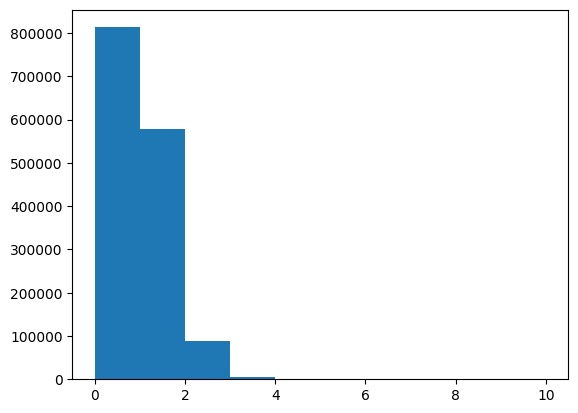

In [31]:
plt.hist(concurrency)

## Save events to disk

In [32]:
labeled_events.to_pickle(DIRECTION_LABEL_FILE_PATH)